# Activity proxies in Myanmar
## Introduction
This document presents an assessment of Veraset data to be used as an estimation of Mobility in Myanmar. 


## About Veraset Movement Data
Veraset Movement is an unfiltered stream of location and proximity data that Veraset has aggregated from data suppliers. 

How does Veraset source its data?

Veraset sources data from direct relationships with third-party applications and software development kits (SDKs) as well as data aggregators. It is then cleansed for data sinks and other anomalies and deduplicated by event date. [Source](https://www.veraset.com/solutions/movement)

Can Veraset reveal the sources of its data?

While Veraset obtains data from a variety of sources, it does not typically disclose the specific sources of its data. This is to protect the privacy and confidentiality of its data providers. However, Veraset is committed to transparency and ensures that all its data is sourced in accordance with applicable laws and ethical guidelines.[Source](https://www.veraset.com/solutions/movement)

In [3]:
# !pip install pandas "dask[complete]" pyarrow plotly
# !pip install --upgrade s3fs

In [2]:
import pandas as pd

# import geopandas as gpd
import dask.dataframe as dd

# import pytz
import datetime

# from shapely import Point
# import numpy as np
from dask.distributed import Client
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Veraset Sample
This step creates an assessment of Veraset Movement Data for Maynmar between January 2020 to March 2024.

### Repartition the data
To make a more efficient use of the resources, we are reading and saving the data by year and month. 

In [3]:
client = Client(n_workers=1)
client

In [4]:
## Repartition the data by year and month
# for year in [2021,2022,2023,2024]:
#     for month in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
#         print(year, month)
#         try:
#             path = 's3://wbgggscecovid19dev-mobility/veraset/country=MM/year={}/date={}-{}-*/*.parquet'.format(year, year, month)
#             ddf = dd.read_parquet(path)
#             df = ddf.compute()
#             df.to_parquet('./data/data_{}_{}.parquet'.format(year, month))
#         except:
#             pass

### Number of Users across the years
The first step in the analysis consists on determining how many users were registered across the years in the region. From 2020 to March 2021, we observe considerable daily variations in number of users. Around March 2021, we observe a stark decline in number of users that might be related to the begining of internet restrictions. In October of 2021, we observe an increase in number of users that falls again around mid March of 2022, **which might be related to changes policies about how location data is collected**. After that, the number of users stayed stable and considerably low with respect to 2020. 

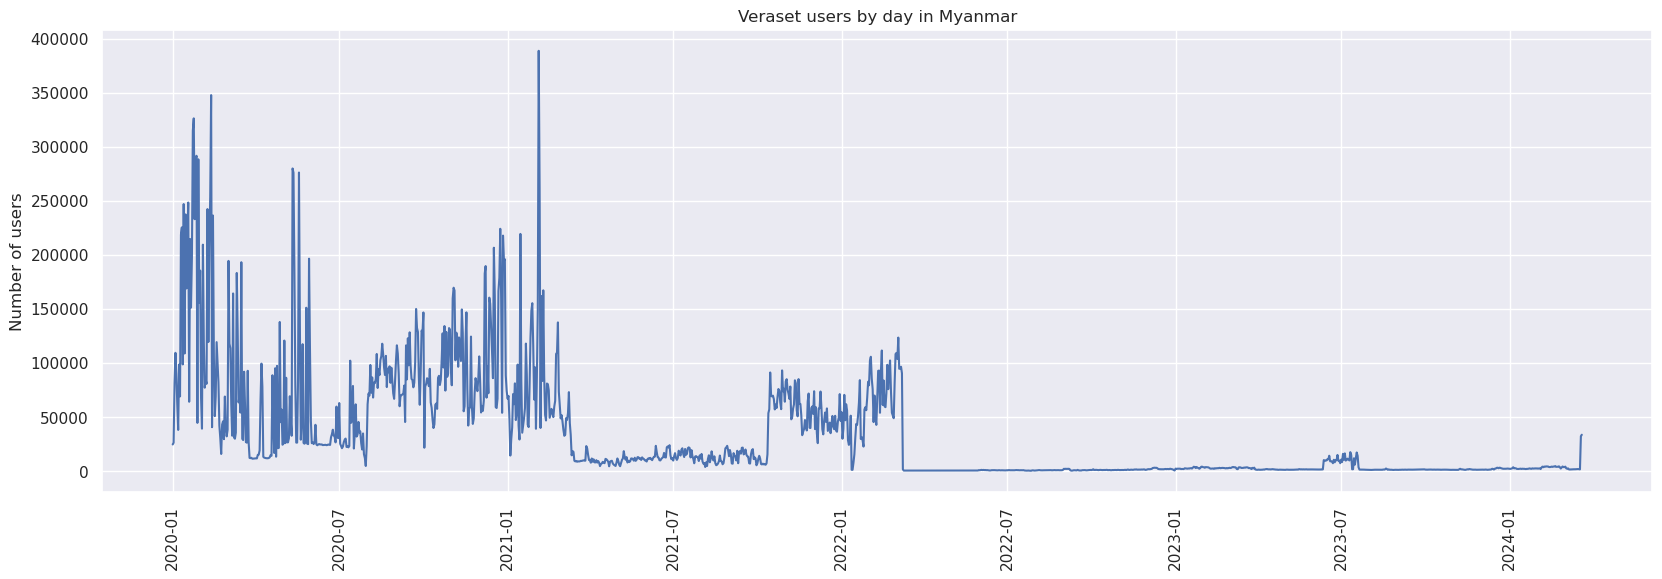

In [5]:
path = "./data/data_*.parquet"
columns = ["uid", "datetime", "hex_id"]
ddf = dd.read_parquet(path, columns=columns)
ddf["datetime"] = dd.to_datetime(ddf["datetime"])
ddf["local_datetime"] = ddf["datetime"].dt.tz_convert("Asia/Yangon")
ddf["local_datetime"] = ddf["local_datetime"].dt.tz_convert(None)
ddf["date"] = ddf["local_datetime"].dt.date
ddf["year"] = ddf.local_datetime.dt.year
ddf["month"] = ddf.local_datetime.dt.month

agg_by_day = ddf.groupby(["date"])["uid"].nunique().compute()
agg_by_day = agg_by_day.to_frame()
agg_by_day.sort_values("date", inplace=True)

plt.figure(figsize=(20, 6))
plt.plot(agg_by_day.index, agg_by_day.uid)
plt.ylabel("Number of users")
plt.title("Veraset users by day in Myanmar")
plt.xticks(rotation=90)
plt.show();

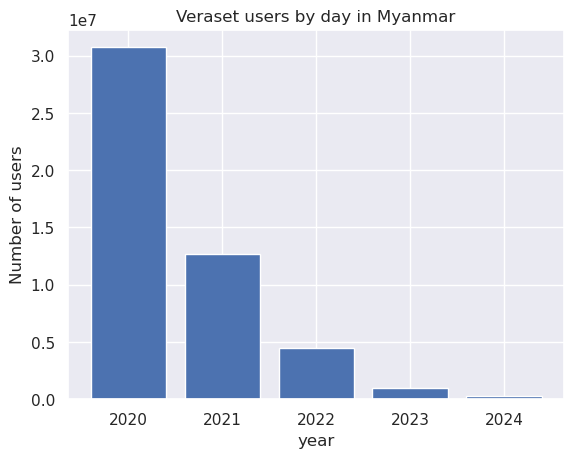

In [6]:
data = agg_by_day.reset_index()
data["date_str"] = data.date.astype("str")
data["month"] = data["date"].apply(lambda x: x.month)
data["year"] = data["date"].apply(lambda x: str(x.year))
data["month-year"] = data["date_str"].apply(lambda x: x[:7])
agg_by_year = data.groupby("year").uid.sum()

plt.bar(agg_by_year.index, agg_by_year)
plt.title("Veraset users by day in Myanmar")
plt.xlabel("year")
plt.ylabel("Number of users");

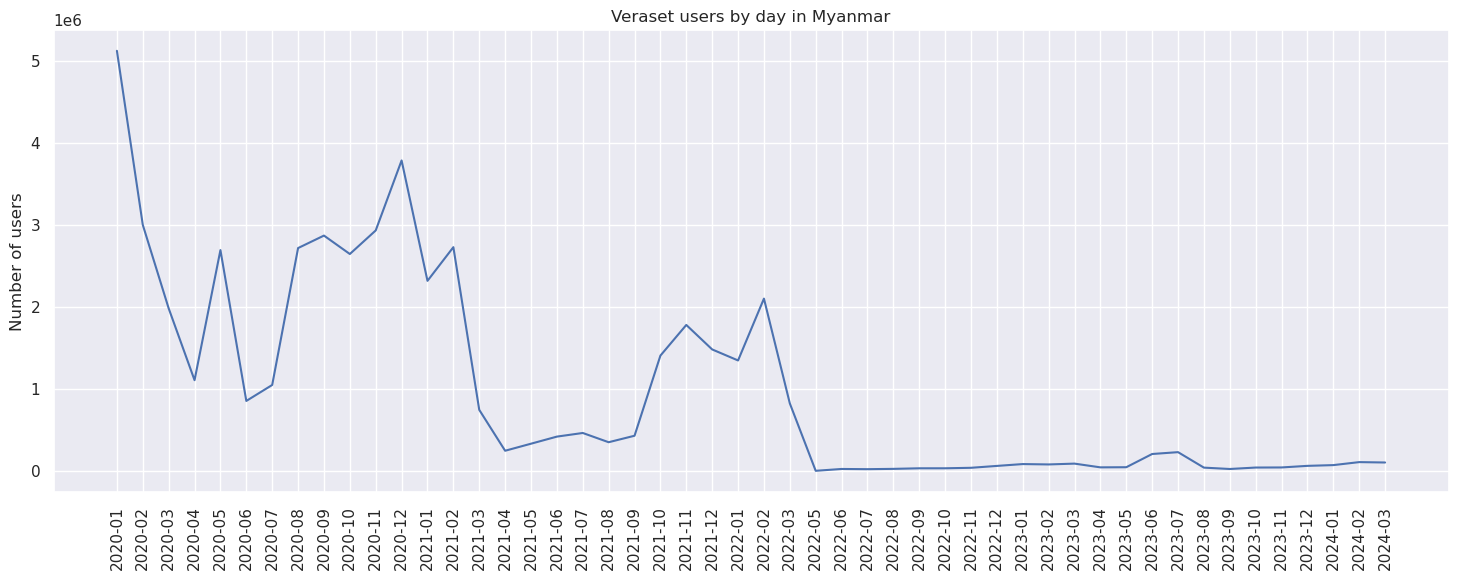

In [7]:
agg_by_month_year = data.groupby("month-year").uid.sum()
plt.figure(figsize=(18, 6))
plt.plot(agg_by_month_year.index, agg_by_month_year)
plt.ylabel("Number of users")
plt.title("Veraset users by day in Myanmar")
plt.xticks(rotation=90);

### ID type

In [12]:
path = "./data/data*.parquet"
columns = ["uid", "datetime", "id_type"]
ddf = dd.read_parquet(path, columns=columns)

In [1]:
# ddf.groupby(['uid', 'id_type']).size().head()

In [ ]:
agg_by_id_type

### Pings per user distribution
We also studied the number of pings (connections) a user had across the years to understand whether the data can be used for longitudinal analysis. The two boxplots below are showing the same information but the boxplot on the right has limited its x-axis to 100 so that we can observe with greater detail users that had less than a 100 pings across the 4 years. We can observe that 75% of users had less than 28 pings across the 4 years. 

In [8]:
path = "./data/data*.parquet"
columns = ["uid", "datetime", "id_type"]
ddf = dd.read_parquet(path, columns=columns)

In [12]:
pings_per_user = ddf.groupby("uid").size().compute()

In [7]:
pings_per_user.describe()

count    7.132994e+06
mean     1.204889e+02
std      1.454482e+03
min      1.000000e+00
25%      2.000000e+00
50%      7.000000e+00
75%      2.800000e+01
max      5.237190e+05
dtype: float64

In [8]:
pings_per_user = pings_per_user.to_frame()
pings_per_user.rename(columns={0: "pings"}, inplace=True)

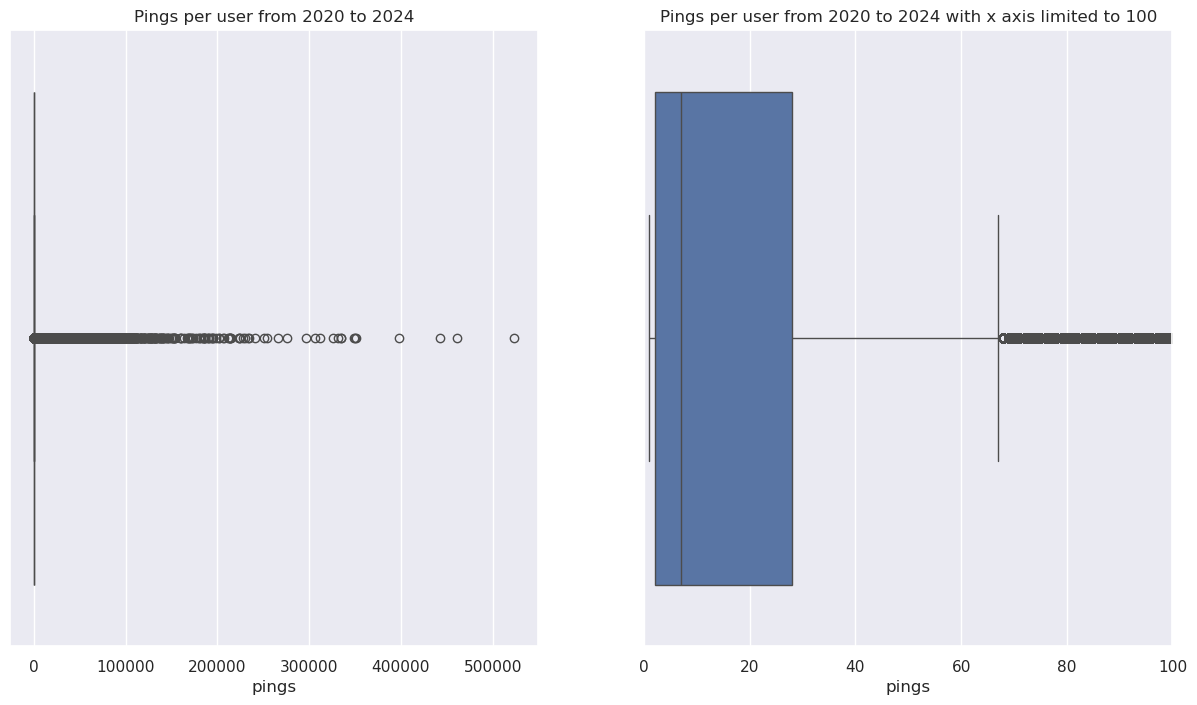

In [16]:
# create a subplot by year
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
sns.boxplot(x=pings_per_user["pings"], ax=ax[0])
ax[0].title.set_text("Pings per user from 2020 to 2024")
sns.boxplot(x=pings_per_user["pings"], ax=ax[1])
ax[1].set_xlim([0, 100])
ax[1].title.set_text("Pings per user from 2020 to 2024 with x axis limited to 100")
plt.show()

### Pings per user across each month
Next, we analyze the distribution of pings per users across each month. We can observe that across the years, most of the users in the sample have less than 30 ping per month which we could translate to approximately, less than 1 ping per day. Similar to what we did above, the second boxplot shows the same information as the first one but limited the x-axis to have a gretare detail in the area where most of the sample is concentrated, low number of pings per month.

2024-05-03 19:01:02,099 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 87.28 GiB -- Worker memory limit: 124.46 GiB


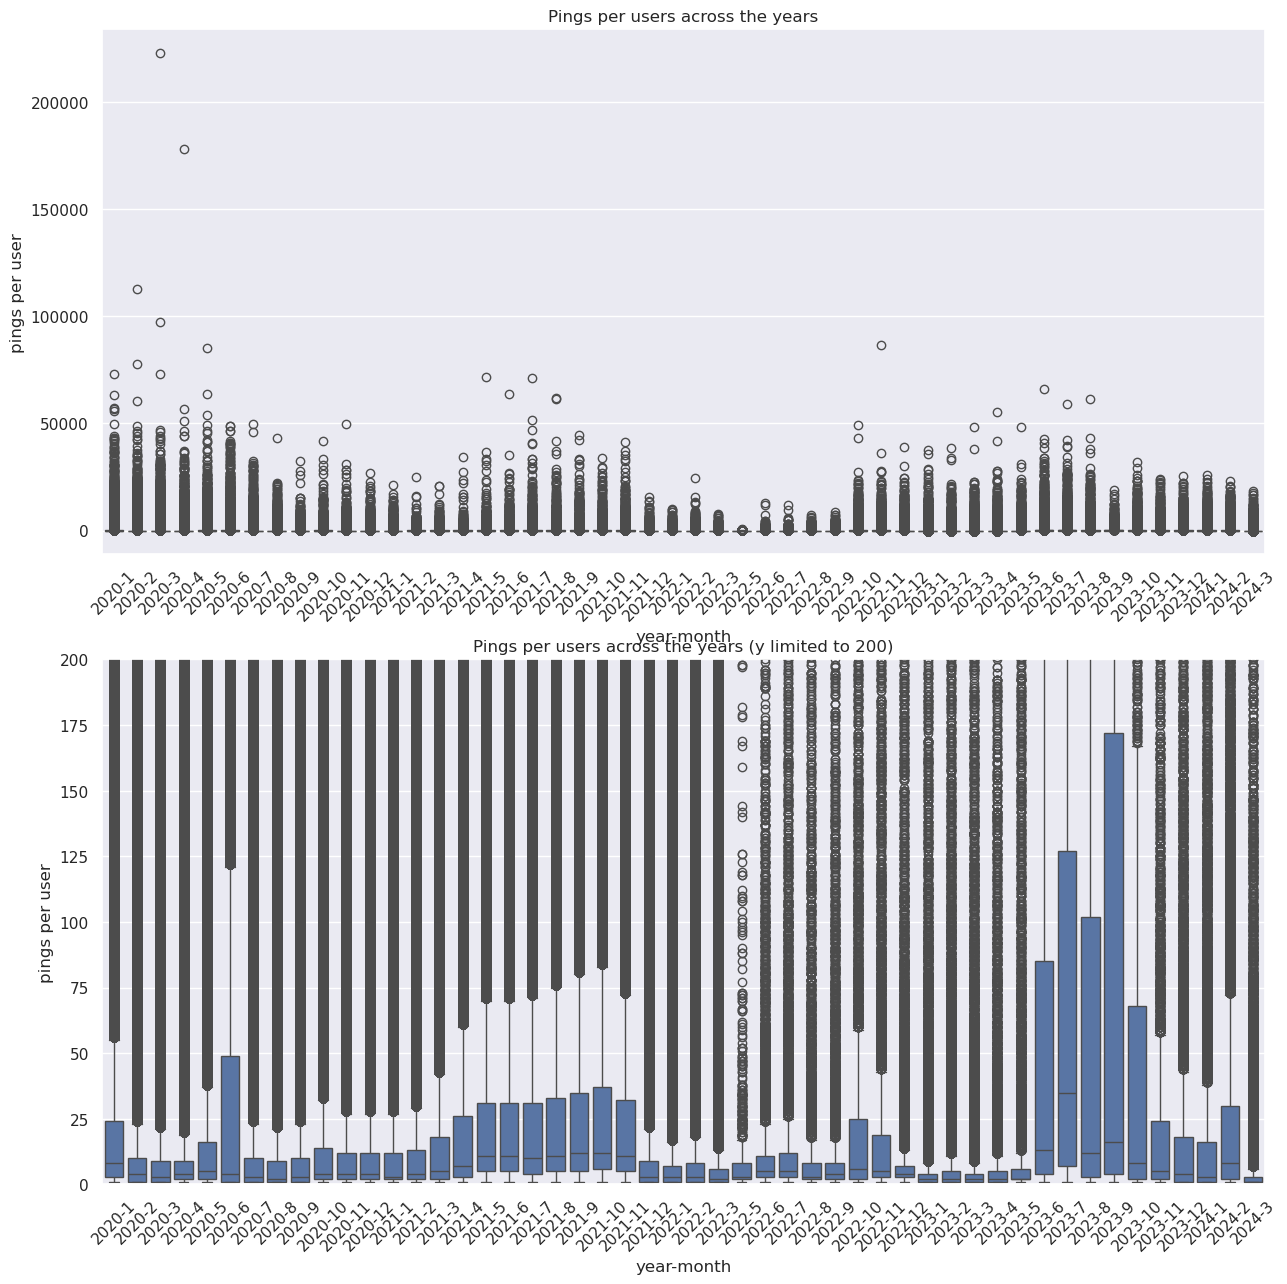

In [4]:
path = "./data/data_*.parquet"
columns = ["uid", "datetime", "hex_id"]
ddf = dd.read_parquet(path, columns=columns)
ddf["datetime"] = dd.to_datetime(ddf["datetime"])
ddf["local_datetime"] = ddf["datetime"].dt.tz_convert("Asia/Yangon")
ddf["local_datetime"] = ddf["local_datetime"].dt.tz_convert(None)
ddf["date"] = ddf["local_datetime"].dt.date
ddf["year"] = ddf.local_datetime.dt.year
ddf["month"] = ddf.local_datetime.dt.month
agg_by_year_month = ddf.groupby(["year", "month", "uid"]).size().compute()
agg_by_year_month = agg_by_year_month.reset_index()
agg_by_year_month.rename(columns={0: "pings/user"}, inplace=True)
agg_by_year_month["year-month"] = agg_by_year_month.apply(
    lambda row: "{}-{}".format(row.year, row.month), axis=1
)

# create a subplot by year
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
sns.boxplot(data=agg_by_year_month, x="year-month", y="pings/user", ax=ax[0])
ax[0].tick_params(axis="x", rotation=45)
ax[0].set_xlabel("year-month")
ax[0].set_ylabel("pings per user")
ax[0].title.set_text("Pings per users across the years")

sns.boxplot(data=agg_by_year_month, x="year-month", y="pings/user", ax=ax[1])
ax[1].set_ylim([0, 200])
ax[1].tick_params(axis="x", rotation=45)
ax[1].set_xlabel("year-month")
ax[1].set_ylabel("pings per user")
ax[1].title.set_text("Pings per users across the years (y limited to 200)")

plt.show()

### Users suitable for a longitudinal analysis
In order to perform a longitudinal analysis, we are filtering the data to keep only useres that had at least 30 pings in a month, which are around 2,500,000. 
Then, we check for how many months these users keep these level of connection intensity. We observe that 75% of the users were able to keep the 30 pings per month for less than 2 months of the total 51 months. None of the users were able to keep the 30 pings per month across the 4 years.  


Records where pings per user are greater than 30

In [5]:
len(agg_by_year_month[agg_by_year_month["pings/user"] > 30])

2569312

In [6]:
agg_by_year_month[agg_by_year_month["pings/user"] > 30].groupby("uid").size().describe()

count    1.345974e+06
mean     1.908887e+00
std      1.840105e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.500000e+01
dtype: float64

### Pings by date
Another way to assess the data is by studying the number of pings registered by date. The plot seems to be correlated with number of users per date. The orange line plots the 2nd of April when internet restrictions started according to this [Source](https://www.reuters.com/graphics/MYANMAR-POLITICS/INTERNET-RESTRICTION/rlgpdbreepo/)

In [2]:
pings_by_date = ddf.groupby(["date"])["uid"].size().compute()

In [29]:
pings_by_date = pings_by_date.reset_index()
pings_by_date.rename(columns={"uid": "pings"}, inplace=True)
pings_by_date.sort_values("date", inplace=True)

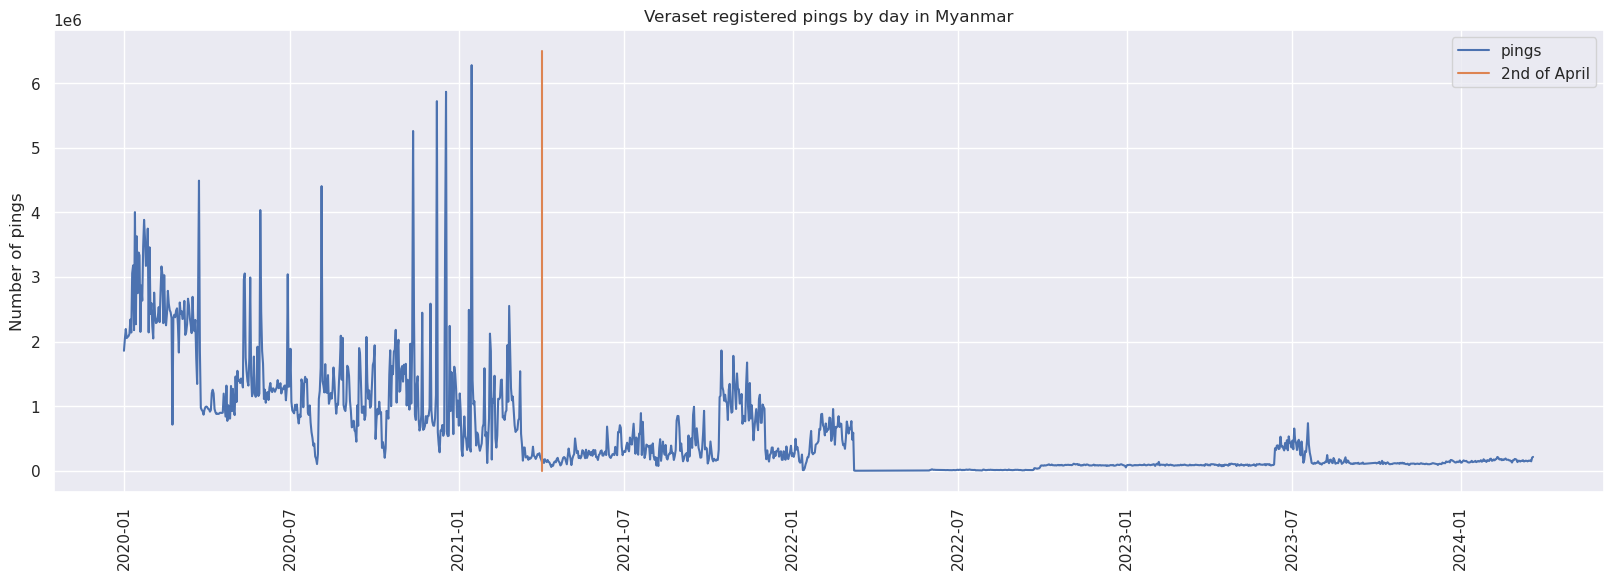

In [34]:
plt.figure(figsize=(20, 6))
plt.plot(pings_by_date.date, pings_by_date.pings, label="pings")
plt.plot(
    [
        datetime.date(year=2021, month=4, day=2),
        datetime.date(year=2021, month=4, day=2),
    ],
    [0, 6500000],
    label="2nd of April",
)
plt.ylabel("Number of pings")
plt.title("Veraset registered pings by day in Myanmar")
plt.xticks(rotation=90)
plt.legend()
plt.show();

### By region 
Finally, we studied the number of pings by date and number of users by date across four regions:
- The North: Kachin, Shan (North)
- The Central: Sagaing, Magway, Mandalay
- The South: Mon, Kayin, Kayah, Tanintharyi, Bago (East) 
- The West: Rakhine, Chin
- The Other: Yangon, Ayeyarwady,Nay Pyi Taw, Bago (West), Shan (South), Shan (East)
Then, we compared the two variables with the conflict index by region. At first sight, there does not seem to be a correlation between neither number of pings nor number of users with conflict index.

In [4]:
import geopandas as gpd
import h3
import shapely

In [6]:
admin1 = gpd.read_file("./data/mmr_polbnda_adm2_250k_mimu_1.shp")

In [7]:
def get_h3_tessellation(gdf: gpd.GeoDataFrame, name="shapeName", resolution=10):
    mapper = dict()
    h3_tessellation = set()

    # TODO: vectorize, if possible
    for idx, row in gdf.iterrows():
        geometry = row["geometry"]

        match geometry.geom_type:
            case "Polygon":
                hex_ids = h3.polyfill(
                    shapely.geometry.mapping(geometry),
                    resolution,
                    geo_json_conformant=True,
                )

                h3_tessellation = h3_tessellation.union(set(hex_ids))
                mapper.update([(hex_id, row[name]) for hex_id in hex_ids])

            case "MultiPolygon":
                for x in geometry.geoms:
                    hex_ids = h3.polyfill(
                        shapely.geometry.mapping(x),
                        resolution,
                        geo_json_conformant=True,
                    )

                    h3_tessellation = h3_tessellation.union(set(hex_ids))
                    mapper.update([(hex_id, row[name]) for hex_id in hex_ids])
            case _:
                raise (Exception)

    return mapper, h3_tessellation

In [8]:
path = "./data/data_*.parquet"
columns = ["uid", "datetime", "hex_id"]
ddf = dd.read_parquet(path, columns=columns)
ddf["datetime"] = dd.to_datetime(ddf["datetime"])
ddf["local_datetime"] = ddf["datetime"].dt.tz_convert("Asia/Yangon")
ddf["local_datetime"] = ddf["local_datetime"].dt.tz_convert(None)
ddf["date"] = ddf["local_datetime"].dt.date
ddf["year"] = ddf.local_datetime.dt.year
ddf["month"] = ddf.local_datetime.dt.month

In [9]:
mapper, h3_tessellation = get_h3_tessellation(admin1, name="ST", resolution=7)

In [10]:
mapper_df = pd.DataFrame.from_dict(mapper, orient="index")
mapper_df.rename(columns={0: "admin1"}, inplace=True)

In [11]:
region_dict = {
    "Kachin": "North",
    "Shan (North)": "North",
    "Sagaing": "Central",
    "Magway": "Central",
    "Mandalay": "Central",
    "Mon": "South",
    "Kayin": "South",
    "Kayah": "South",
    "Tanintharyi": "South",
    "Bago (East)": "South",
    "Rakhine": "West",
    "Chin": "West",
    "Yangon": "Other",
    "Ayeyarwady": "Other",
    "Nay Pyi Taw": "Other",
    "Bago (West)": "Other",
    "Shan (South)": "Other",
    "Shan (East)": "Other",
}

In [12]:
mapper_df["region"] = mapper_df["admin1"].apply(lambda x: region_dict[x])

In [18]:
ddf_ping_admin1 = dd.merge(
    ddf, mapper_df, how="left", left_on="hex_id", right_index=True
)
agg_pings_by_date = ddf_ping_admin1.groupby(["region", "date"])["uid"].size().compute()
agg_pings_by_date = agg_pings_by_date.to_frame()
agg_pings_by_date.sort_values("date", inplace=True)
agg_pings_by_date.rename(columns={"uid": "pings"}, inplace=True)
agg_pings_by_date = agg_pings_by_date.reset_index()

2024-05-03 20:35:40,148 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-05-03 20:36:10,580 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


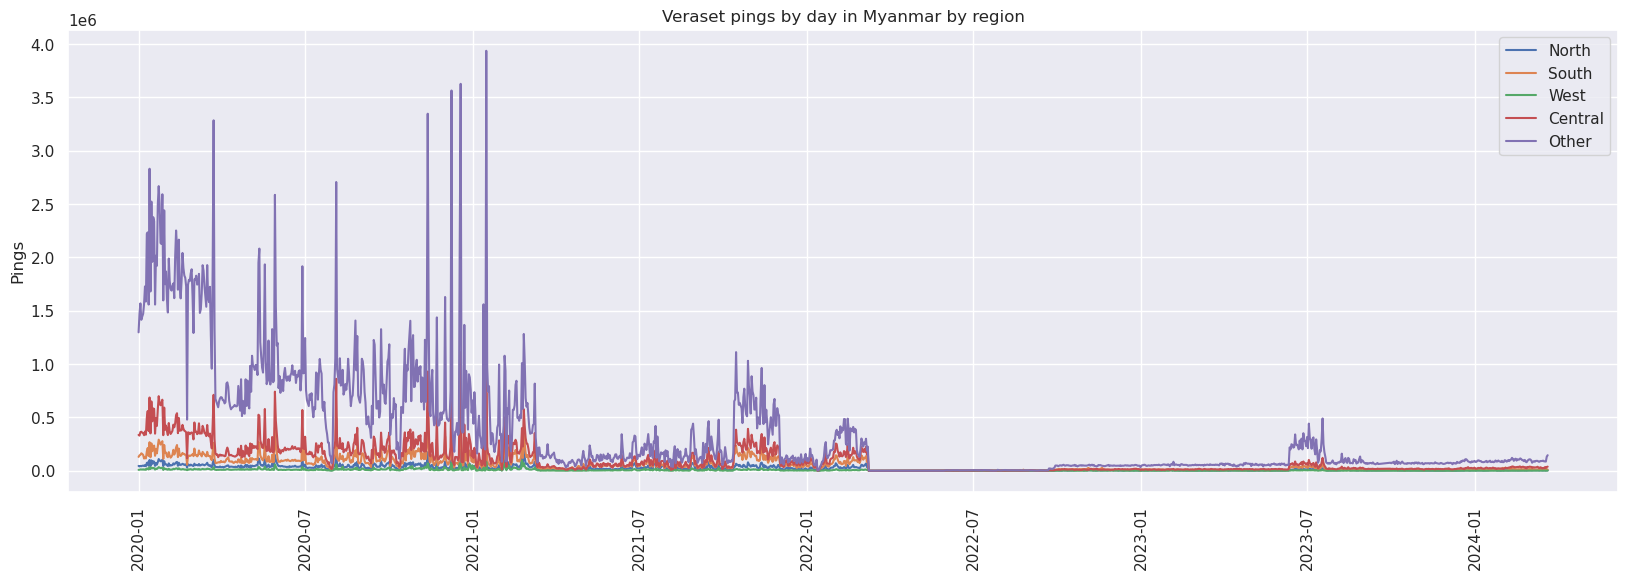

In [23]:
plt.figure(figsize=(20, 6))
for region in ["North", "South", "West", "Central", "Other"]:
    data = agg_pings_by_date[agg_pings_by_date["region"] == region].copy()
    plt.plot(data.date, data.pings, label=region)

plt.ylabel("Pings")
plt.title("Veraset pings by day in Myanmar by region")
plt.xticks(rotation=90)
plt.legend()
plt.show();

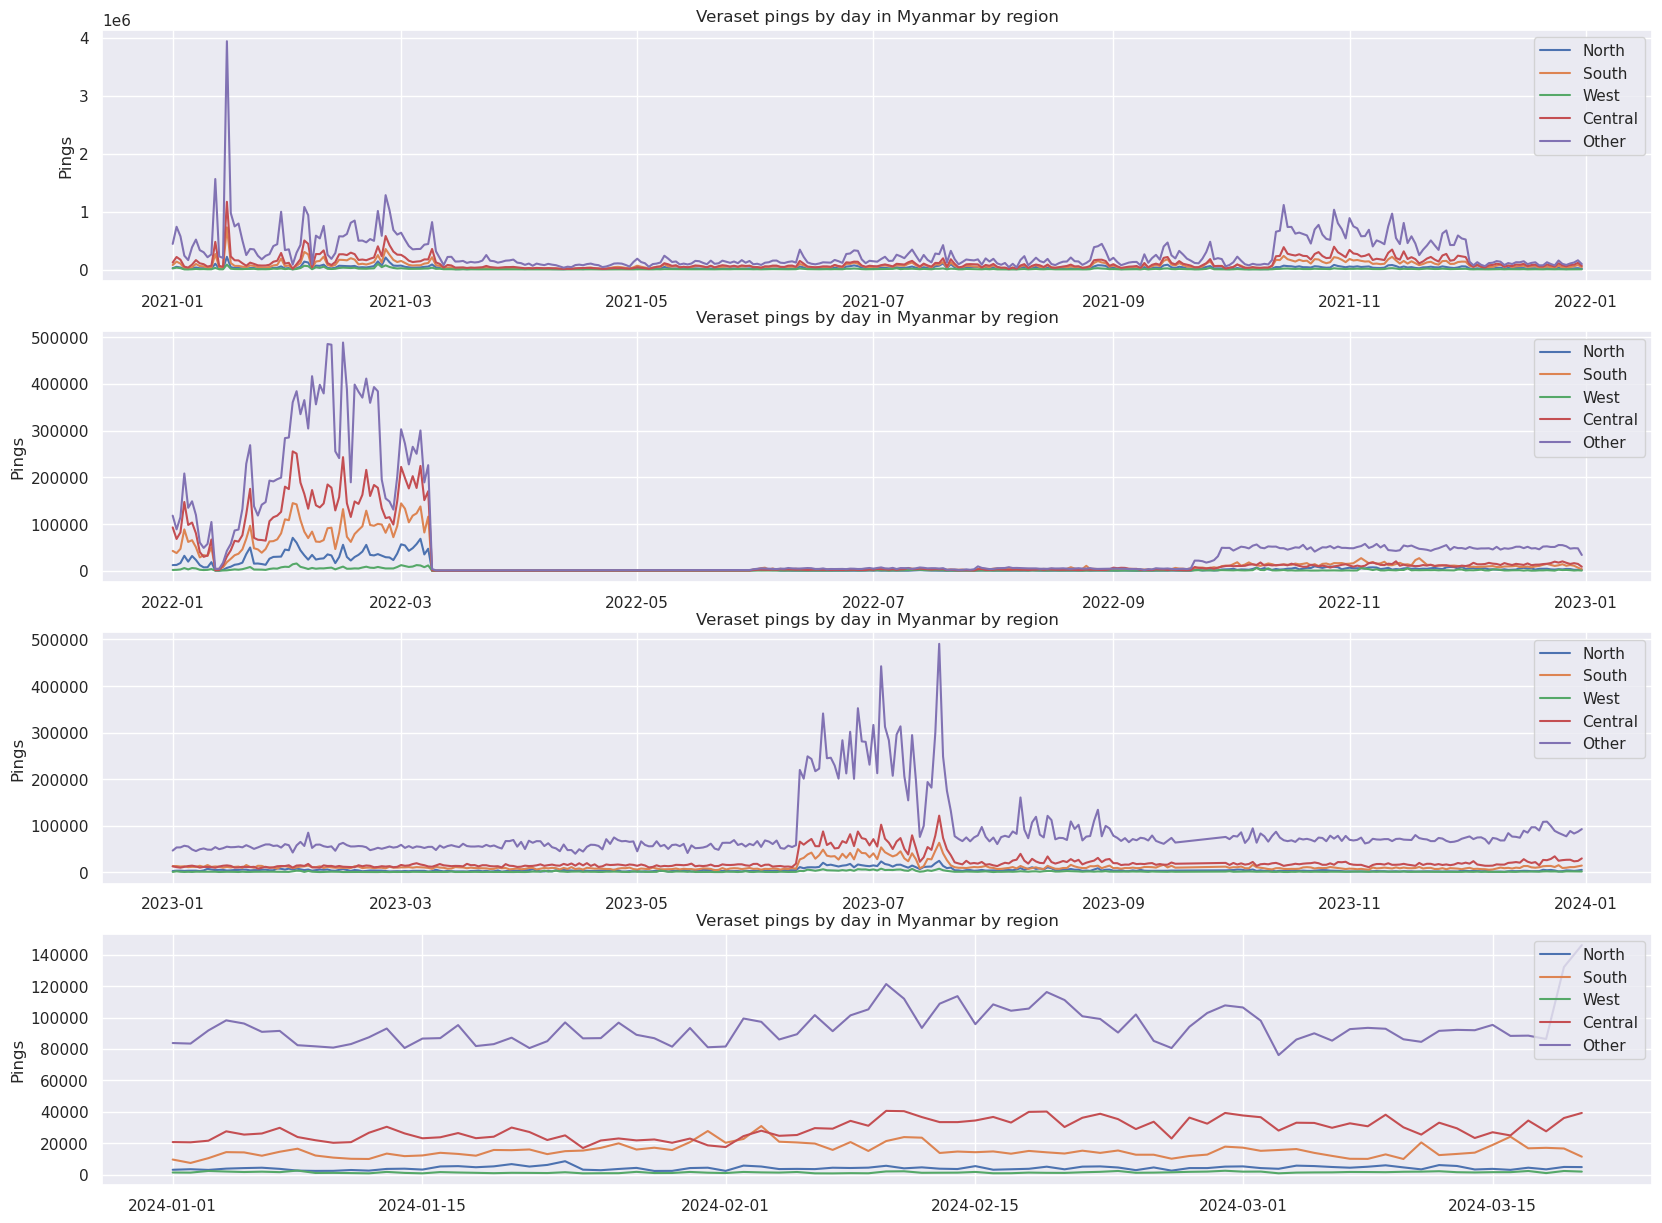

In [24]:
# create a subplot by year
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 15))
year_grid = {2021: [0, 1], 2022: [1, 1], 2023: [2, 1], 2024: [3, 1]}
agg_pings_by_date["year"] = agg_pings_by_date["date"].apply(lambda x: x.year)
for year, grid in year_grid.items():
    for region in ["North", "South", "West", "Central", "Other"]:
        data = agg_pings_by_date[
            (agg_pings_by_date["year"] == year)
            & (agg_pings_by_date["region"] == region)
        ].copy()
        ax[grid[0]].plot(data.date, data.pings, label=region)

    ax[grid[0]].set_ylabel("Pings")
    ax[grid[0]].set_title("Veraset pings by day in Myanmar by region")
    ax[grid[0]].legend()
plt.savefig("number_users_by_year.png")
plt.show();

In [14]:
ddf_admin1 = dd.merge(ddf, mapper_df, how="left", left_on="hex_id", right_index=True)

In [15]:
agg_region_date = ddf_admin1.groupby(["region", "date"])["uid"].nunique()
agg_region_date = agg_region_date.compute()

In [17]:
agg_region_date = agg_region_date.reset_index()

In [18]:
agg_region_date.rename(columns={"uid": "number_users"}, inplace=True)

In [19]:
agg_region_date.sort_values("date", inplace=True)

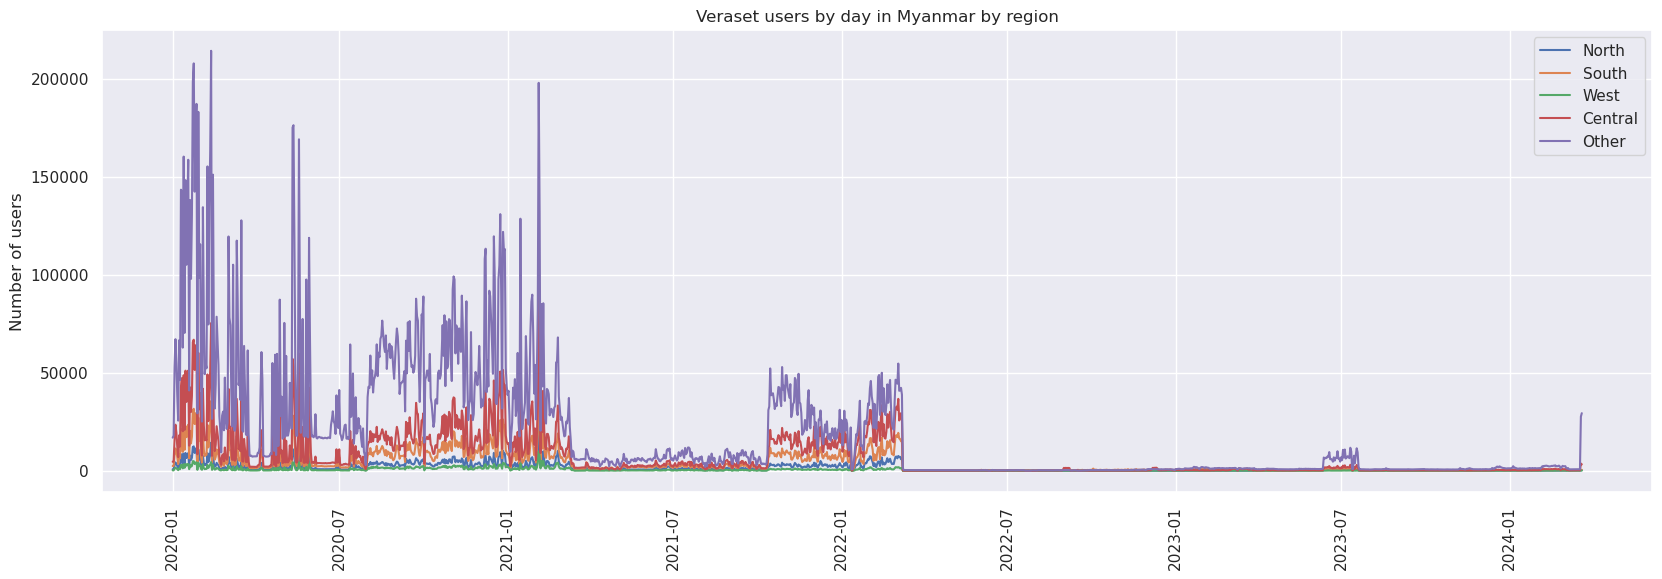

In [20]:
plt.figure(figsize=(20, 6))
for region in ["North", "South", "West", "Central", "Other"]:
    data = agg_region_date[agg_region_date["region"] == region].copy()
    plt.plot(data.date, data.number_users, label=region)

plt.ylabel("Number of users")
plt.title("Veraset users by day in Myanmar by region")
plt.xticks(rotation=90)
plt.legend()
plt.show();

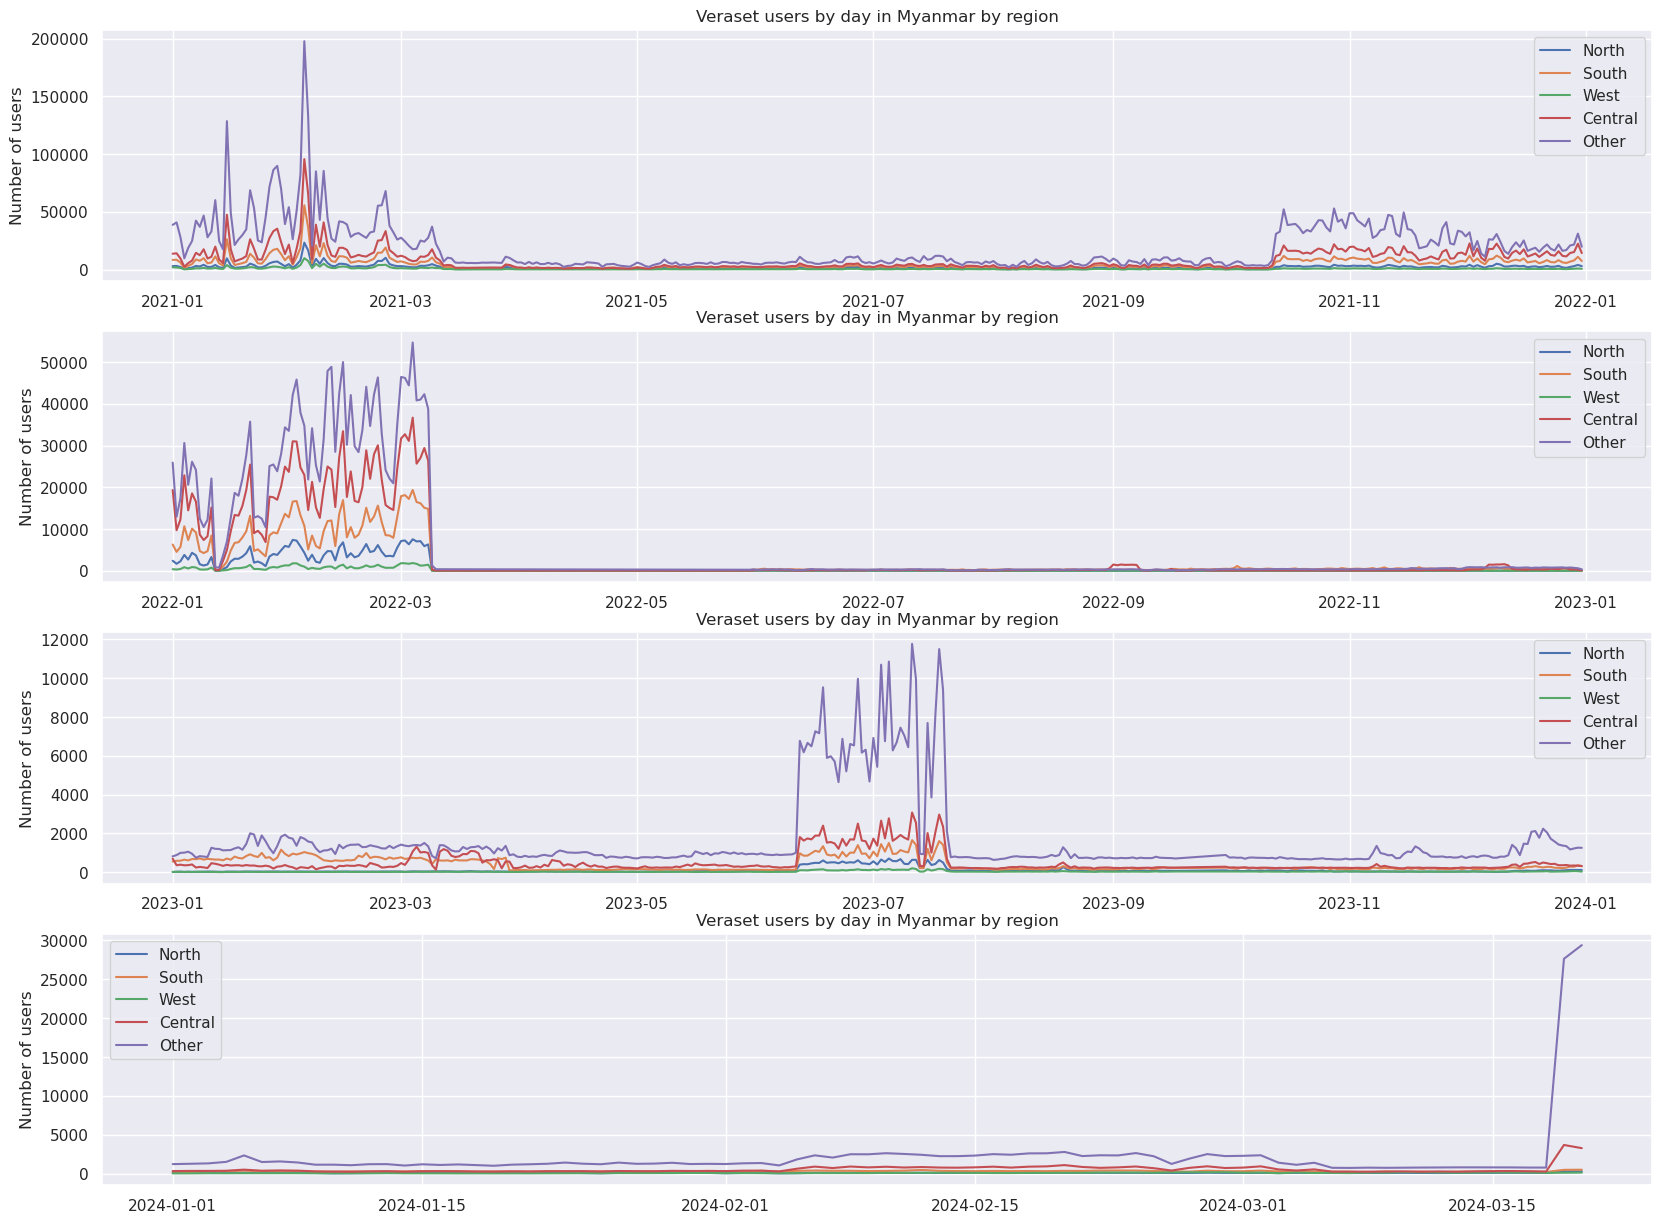

In [21]:
# create a subplot by year
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 15))
year_grid = {2021: [0, 1], 2022: [1, 1], 2023: [2, 1], 2024: [3, 1]}
agg_region_date["year"] = agg_region_date["date"].apply(lambda x: x.year)
for year, grid in year_grid.items():
    for region in ["North", "South", "West", "Central", "Other"]:
        data = agg_region_date[
            (agg_region_date["year"] == year) & (agg_region_date["region"] == region)
        ].copy()
        ax[grid[0]].plot(data.date, data.number_users, label=region)

    ax[grid[0]].set_ylabel("Number of users")
    ax[grid[0]].set_title("Veraset users by day in Myanmar by region")
    ax[grid[0]].legend()
plt.savefig("number_users_by_year.png")
plt.show();

In [70]:
conflict = pd.read_excel(
    "./data/Analysis_ACLED_01_Jan_2021_29_Mar_2024_regional_weekly.xlsx",
    sheet_name="Normalized_Conflict",
    skiprows=2,
)

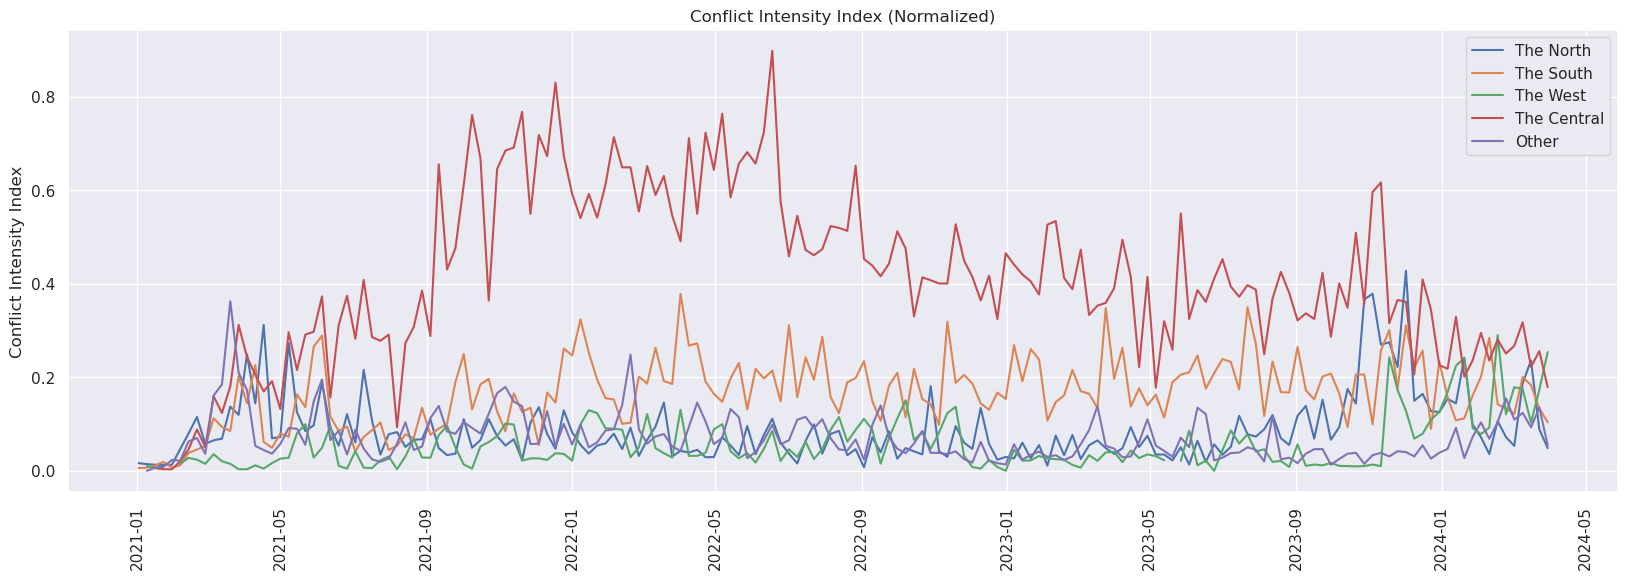

In [76]:
plt.figure(figsize=(20, 6))
for region in ["The North", "The South", "The West", "The Central", "Other"]:
    plt.plot(conflict.Week, conflict[region], label=region)
plt.legend()
plt.title("Conflict Intensity Index (Normalized)")
plt.ylabel("Conflict Intensity Index")
plt.xticks(rotation=90);

## Conclusions
We observe that Veraset data varies considerably across the studied period. Unfortunately, we cannot attribute this to a cause, although we hypothesize that this could be related to restrictions to the internet access as well as changes in data collection policies. 

In order to use this data for mobility analysis we need to have users that have several connections per day and maintain the connection intensity across the months. Across the four years, the number of users suitable for these type of longitudinal analysis is low. However, the sample might be useful for shorter analysis timespans, subject to the analysis of the data in different timespans.